In [1]:
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')
spark = SparkSession.builder.appName('FraudDetection').getOrCreate()
df = spark.read.csv('merge_2025-07-03.csv', header=True, inferSchema=True)
df.limit(5).toPandas()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/05 12:20:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,TransactionID,Amount,Time,UserID,Location,Merchant,Class
0,2049,78.43,55330,1431,NY,Target,0
1,2050,8.53,32991,1519,FL,Target,0
2,2051,61.30,15003,1789,FL,Amazon,0
3,2052,66.30,47496,1323,WA,Target,0
4,2053,18.13,14743,1801,CA,eBay,0


In [2]:
df.printSchema()

root
 |-- TransactionID: integer (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Time: integer (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Merchant: string (nullable = true)
 |-- Class: integer (nullable = true)



In [3]:
df.groupBy('Class').count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    1|  294|
|    0|17658|
+-----+-----+



In [4]:
df.select('Amount').describe().show()

+-------+-----------------+
|summary|           Amount|
+-------+-----------------+
|  count|            17952|
|   mean| 99.7499008467023|
| stddev|99.66327841486451|
|    min|              0.0|
|    max|           949.57|
+-------+-----------------+



In [5]:
df.groupby('Class').avg('Amount').show()

+-----+------------------+
|Class|       avg(Amount)|
+-----+------------------+
|    1|100.11884353741495|
|    0| 99.74375806999662|
+-----+------------------+



In [6]:
df.filter(df.Class==1).groupby('Location').count().orderBy("count", ascending=False).show()

+--------+-----+
|Location|count|
+--------+-----+
|      CA|   61|
|      WA|   59|
|      NY|   59|
|      FL|   58|
|      TX|   57|
+--------+-----+



In [7]:
df.groupBy('Merchant').avg('Amount').show()

+--------+------------------+
|Merchant|       avg(Amount)|
+--------+------------------+
| Walmart|100.57898044692745|
|  Costco|   99.617076119813|
|  Target| 97.94831794010658|
|    eBay|102.62417765042996|
|  Amazon| 98.09351771117166|
+--------+------------------+



In [8]:
df = df.dropna(subset=['Amount','Time','UserID','Location','Merchant'])

In [9]:
df.limit(5).toPandas()

,TransactionID,Amount,Time,UserID,Location,Merchant,Class
0,2049,78.43,55330,1431,NY,Target,0
1,2050,8.53,32991,1519,FL,Target,0
2,2051,61.30,15003,1789,FL,Amazon,0
3,2052,66.30,47496,1323,WA,Target,0
4,2053,18.13,14743,1801,CA,eBay,0


In [10]:
# Normalize Numerical Features(Amount, Time)
from pyspark.ml.feature import StandardScaler, VectorAssembler

assembler = VectorAssembler(inputCols=['Amount','Time'],
                           outputCol="features_unscaled")
df_vec = assembler.transform(df)

scaler = StandardScaler(inputCol='features_unscaled', outputCol='features_scaled', withMean=True, withStd=True)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

df_scaled.select('Amount','Time','features_scaled').show(5,truncate=False)

+------+-----+-----------------------------------------+
|Amount|Time |features_scaled                          |
+------+-----+-----------------------------------------+
|78.43 |55330|[-0.2139193209955855,0.48934342634698946]|
|8.53  |32991|[-0.9152809570139177,-0.3981191513256183]|
|61.3  |15003|[-0.3857980738567305,-1.1127293329440824]|
|66.3  |47496|[-0.3356291442416853,0.17812171393877024]|
|18.13 |14743|[-0.8189566121530308,-1.1230583660339646]|
+------+-----+-----------------------------------------+
only showing top 5 rows


In [11]:
df = df_scaled

In [12]:
from pyspark.sql.functions import when,col

df = df.withColumn('Hour', (df['Time']/3600).cast('int'))

df = df.withColumn('TimeOfDay',
                  when((col('Hour') >= 5) & (col('Hour')<12), "Morning")
                   .when((col('Hour') >= 12) & (col('Hour')<17), 'Afternoon')
                   .when((col('Hour') >= 17) & (col('Hour')<21), 'Evening')
                   .otherwise('Night')
                  )

In [13]:
# Transaction Frequency per User
from pyspark.sql import functions as F
user_freq = df.groupBy('UserID').agg(
    F.count('*').alias('TransactionFrequency')
)
user_freq.show(4)

+------+--------------------+
|UserID|TransactionFrequency|
+------+--------------------+
|  1645|                  24|
|  1959|                  24|
|  1580|                  25|
|  1238|                  12|
+------+--------------------+
only showing top 4 rows


In [14]:
# Average Amount per User
user_avg = df.groupby('UserID').agg(
    F.avg('Amount').alias('AvgTransactionAmount')
)
user_avg.show(4)

+------+--------------------+
|UserID|AvgTransactionAmount|
+------+--------------------+
|  1645|  128.54666666666665|
|  1959|   72.30874999999999|
|  1580|   72.96840000000002|
|  1238|   76.56416666666668|
+------+--------------------+
only showing top 4 rows


In [15]:
#Join back to original data
df =  df.join(user_freq, on='UserID', how='left').join(user_avg,on='UserID', how='left')

In [16]:
df.limit(5).toPandas()

,UserID,TransactionID,Amount,Time,Location,Merchant,Class,features_unscaled,features_scaled,Hour,TimeOfDay,TransactionFrequency,AvgTransactionAmount
0,1431,2049,78.43,55330,NY,Target,0,"[78.43, 55330.0]","[-0.2139193209955855, 0.48934342634698946]",15,Afternoon,13,78.450769
1,1519,2050,8.53,32991,FL,Target,0,"[8.53, 32991.0]","[-0.9152809570139177, -0.3981191513256183]",9,Morning,10,87.303000
2,1789,2051,61.30,15003,FL,Amazon,0,"[61.3, 15003.0]","[-0.3857980738567305, -1.1127293329440824]",4,Night,21,79.989048
3,1323,2052,66.30,47496,WA,Target,0,"[66.3, 47496.0]","[-0.3356291442416853, 0.17812171393877024]",13,Afternoon,19,79.764211
4,1801,2053,18.13,14743,CA,eBay,0,"[18.13, 14743.0]","[-0.8189566121530308, -1.1230583660339646]",4,Night,20,97.655500


In [17]:
# Encoding Categorical Data

from pyspark.ml.feature import StringIndexer, OneHotEncoder
merchant_ind = StringIndexer(inputCol='Merchant', outputCol='MerchantIndex')
merchant_model = merchant_ind.fit(df)
df = merchant_model.transform(df)

In [18]:
df.limit(5).toPandas()

,UserID,TransactionID,Amount,Time,Location,Merchant,Class,features_unscaled,features_scaled,Hour,TimeOfDay,TransactionFrequency,AvgTransactionAmount,MerchantIndex
0,1431,2049,78.43,55330,NY,Target,0,"[78.43, 55330.0]","[-0.2139193209955855, 0.48934342634698946]",15,Afternoon,13,78.450769,3.0
1,1519,2050,8.53,32991,FL,Target,0,"[8.53, 32991.0]","[-0.9152809570139177, -0.3981191513256183]",9,Morning,10,87.303000,3.0
2,1789,2051,61.30,15003,FL,Amazon,0,"[61.3, 15003.0]","[-0.3857980738567305, -1.1127293329440824]",4,Night,21,79.989048,0.0
3,1323,2052,66.30,47496,WA,Target,0,"[66.3, 47496.0]","[-0.3356291442416853, 0.17812171393877024]",13,Afternoon,19,79.764211,3.0
4,1801,2053,18.13,14743,CA,eBay,0,"[18.13, 14743.0]","[-0.8189566121530308, -1.1230583660339646]",4,Night,20,97.655500,4.0


In [19]:
df.groupby('Merchant').count().show()

+--------+-----+
|Merchant|count|
+--------+-----+
| Walmart| 3580|
|  Costco| 3639|
|  Target| 3573|
|    eBay| 3490|
|  Amazon| 3670|
+--------+-----+



In [20]:
df.groupby('MerchantIndex').count().show()

+-------------+-----+
|MerchantIndex|count|
+-------------+-----+
|          0.0| 3670|
|          1.0| 3639|
|          4.0| 3490|
|          3.0| 3573|
|          2.0| 3580|
+-------------+-----+



In [21]:
encoder = OneHotEncoder(inputCols=['MerchantIndex'], outputCols=['MerchantVec'])
df = encoder.fit(df).transform(df)

In [22]:
df.limit(5).toPandas()

,UserID,TransactionID,Amount,Time,Location,Merchant,Class,features_unscaled,features_scaled,Hour,TimeOfDay,TransactionFrequency,AvgTransactionAmount,MerchantIndex,MerchantVec
0,1431,2049,78.43,55330,NY,Target,0,"[78.43, 55330.0]","[-0.2139193209955855, 0.48934342634698946]",15,Afternoon,13,78.450769,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,1519,2050,8.53,32991,FL,Target,0,"[8.53, 32991.0]","[-0.9152809570139177, -0.3981191513256183]",9,Morning,10,87.303000,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,1789,2051,61.30,15003,FL,Amazon,0,"[61.3, 15003.0]","[-0.3857980738567305, -1.1127293329440824]",4,Night,21,79.989048,0.0,"(1.0, 0.0, 0.0, 0.0)"
3,1323,2052,66.30,47496,WA,Target,0,"[66.3, 47496.0]","[-0.3356291442416853, 0.17812171393877024]",13,Afternoon,19,79.764211,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,1801,2053,18.13,14743,CA,eBay,0,"[18.13, 14743.0]","[-0.8189566121530308, -1.1230583660339646]",4,Night,20,97.655500,4.0,"(0.0, 0.0, 0.0, 0.0)"


In [23]:
from pyspark.ml.feature import StringIndexer

# Create the indexer
tod_index = StringIndexer(inputCol='TimeOfDay', outputCol='TimeOfDayIndex')

# Fit it on the DataFrame, not on the indexer itself
indexer_model = tod_index.fit(df)

# Transform the DataFrame
df = indexer_model.transform(df)


In [24]:
tod_index = StringIndexer(inputCol='TimeOfDay', outputCol='TimesOfDayIndex')
df = tod_index.fit(df).transform(df)

In [25]:
tod_encoder = OneHotEncoder(inputCol='TimeOfDayIndex', outputCol='TimeOfDayVec')
df = tod_encoder.fit(df).transform(df)

In [26]:
df.limit(5).toPandas()

,UserID,TransactionID,Amount,Time,Location,Merchant,Class,features_unscaled,features_scaled,Hour,TimeOfDay,TransactionFrequency,AvgTransactionAmount,MerchantIndex,MerchantVec,TimeOfDayIndex,TimesOfDayIndex,TimeOfDayVec
0,1431,2049,78.43,55330,NY,Target,0,"[78.43, 55330.0]","[-0.2139193209955855, 0.48934342634698946]",15,Afternoon,13,78.450769,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,2.0,"(0.0, 0.0, 1.0)"
1,1519,2050,8.53,32991,FL,Target,0,"[8.53, 32991.0]","[-0.9152809570139177, -0.3981191513256183]",9,Morning,10,87.303000,3.0,"(0.0, 0.0, 0.0, 1.0)",1.0,1.0,"(0.0, 1.0, 0.0)"
2,1789,2051,61.30,15003,FL,Amazon,0,"[61.3, 15003.0]","[-0.3857980738567305, -1.1127293329440824]",4,Night,21,79.989048,0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,0.0,"(1.0, 0.0, 0.0)"
3,1323,2052,66.30,47496,WA,Target,0,"[66.3, 47496.0]","[-0.3356291442416853, 0.17812171393877024]",13,Afternoon,19,79.764211,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,2.0,"(0.0, 0.0, 1.0)"
4,1801,2053,18.13,14743,CA,eBay,0,"[18.13, 14743.0]","[-0.8189566121530308, -1.1230583660339646]",4,Night,20,97.655500,4.0,"(0.0, 0.0, 0.0, 0.0)",0.0,0.0,"(1.0, 0.0, 0.0)"


In [27]:
# Convert Pandas for Visualization

sample_df = df.select('Amount','Location','Merchant','Hour','TransactionFrequency','AvgTransactionAmount','Class').sample(False,0.1,
                                                                                                                         seed=42)

In [28]:
pandas_df = sample_df.toPandas()
pandas_df.head(5)

,Amount,Location,Merchant,Hour,TransactionFrequency,AvgTransactionAmount,Class
0,110.57,FL,Walmart,6,20,80.416000,0
1,5.34,NY,eBay,22,23,134.733913,0
2,22.48,FL,eBay,2,13,122.053077,0
3,159.91,TX,eBay,22,17,131.103529,0
4,194.62,CA,eBay,6,17,137.714118,0


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

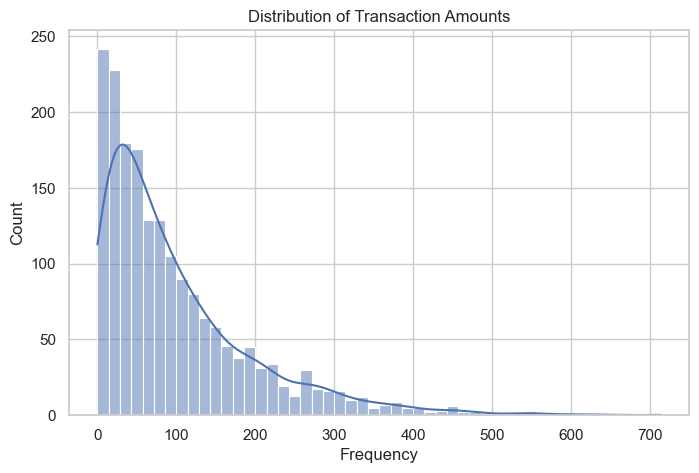

In [30]:
#Transaction Amount Distribution
plt.figure(figsize=(8,5))
sns.histplot(pandas_df['Amount'], bins=50, kde=True,palette='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()

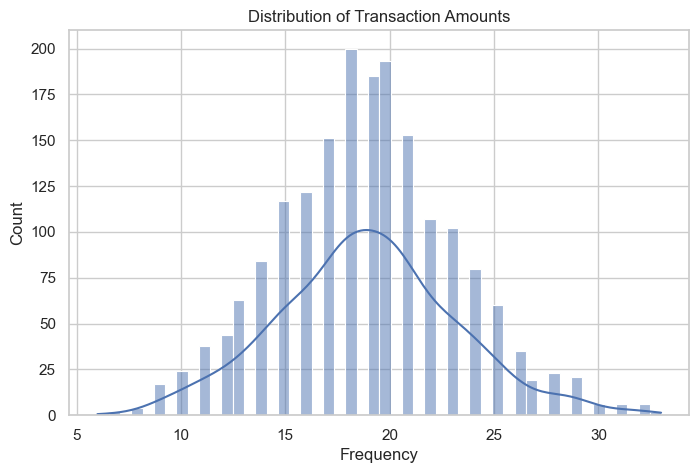

In [31]:
#Transaction Frequency Per User
plt.figure(figsize=(8,5))
sns.histplot(pandas_df['TransactionFrequency'], bins=50, kde=True,palette='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()

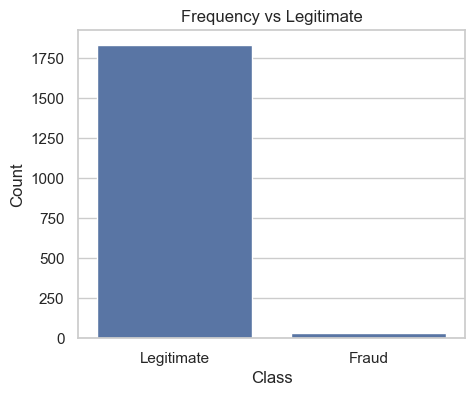

In [32]:
# Frequency vs Legitimate
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data = pandas_df)
plt.title('Frequency vs Legitimate')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0,1],['Legitimate','Fraud'])
plt.show()

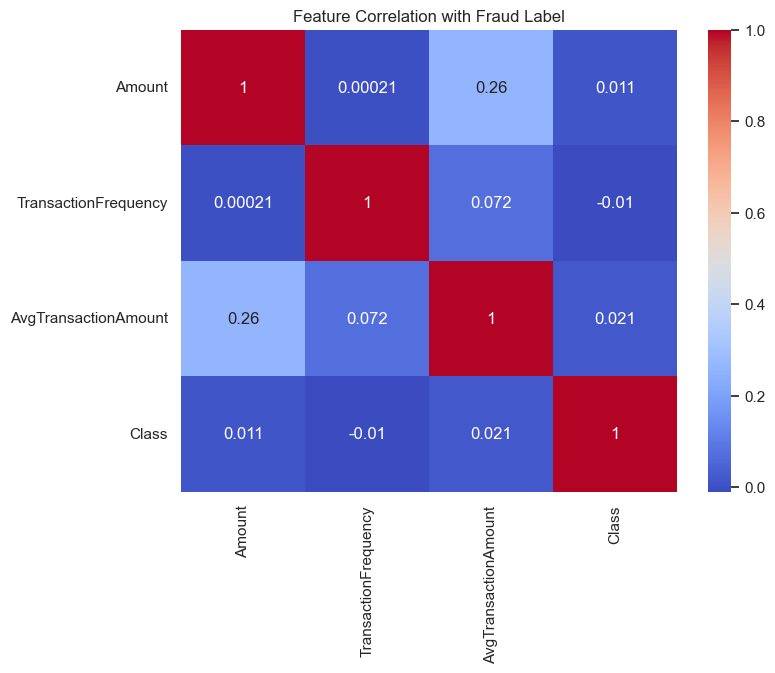

In [33]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
corr = pandas_df[['Amount','TransactionFrequency','AvgTransactionAmount','Class']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Fraud Label')
plt.show()

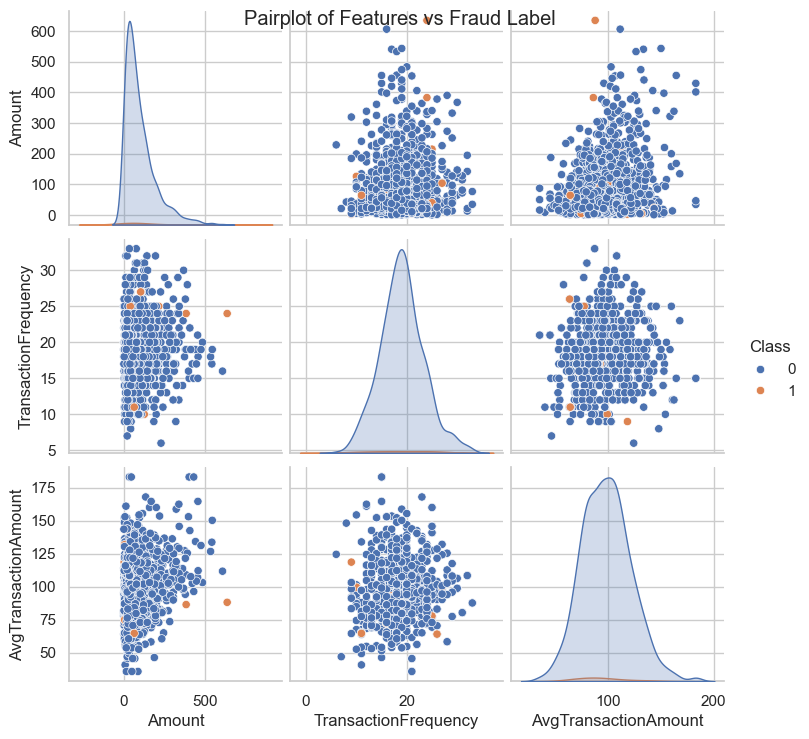

In [34]:
#Pairplot - Downsample for Clarity 
pairplot_df = pandas_df.sample(n=1000, random_state=42)
sns.pairplot(pairplot_df, hue='Class',vars=['Amount','TransactionFrequency','AvgTransactionAmount'])
plt.suptitle("Pairplot of Features vs Fraud Label")
plt.show()

In [35]:
#Undersampling: Lets reduce the majorrity class(class=0) to match the minority class.

fraud = df.filter(df['Class'] == 1)
legit = df.filter(df['Class'] == 0)

fraud_count = fraud.count()
legit_count = legit.count()

print(f'Fraud Count : {fraud_count}')
print(f'Legit Count : {legit_count}')

from pyspark.sql.functions import rand
legit_sampled = legit.orderBy(rand()).limit(fraud_count)
balanced_df = fraud.union(legit_sampled)
balanced_df.groupBy('Class').count().show()

Fraud Count : 294
Legit Count : 17658
+-----+-----+
|Class|count|
+-----+-----+
|    1|  294|
|    0|  294|
+-----+-----+



In [36]:
pandas_df.head()

,Amount,Location,Merchant,Hour,TransactionFrequency,AvgTransactionAmount,Class
0,110.57,FL,Walmart,6,20,80.416000,0
1,5.34,NY,eBay,22,23,134.733913,0
2,22.48,FL,eBay,2,13,122.053077,0
3,159.91,TX,eBay,22,17,131.103529,0
4,194.62,CA,eBay,6,17,137.714118,0


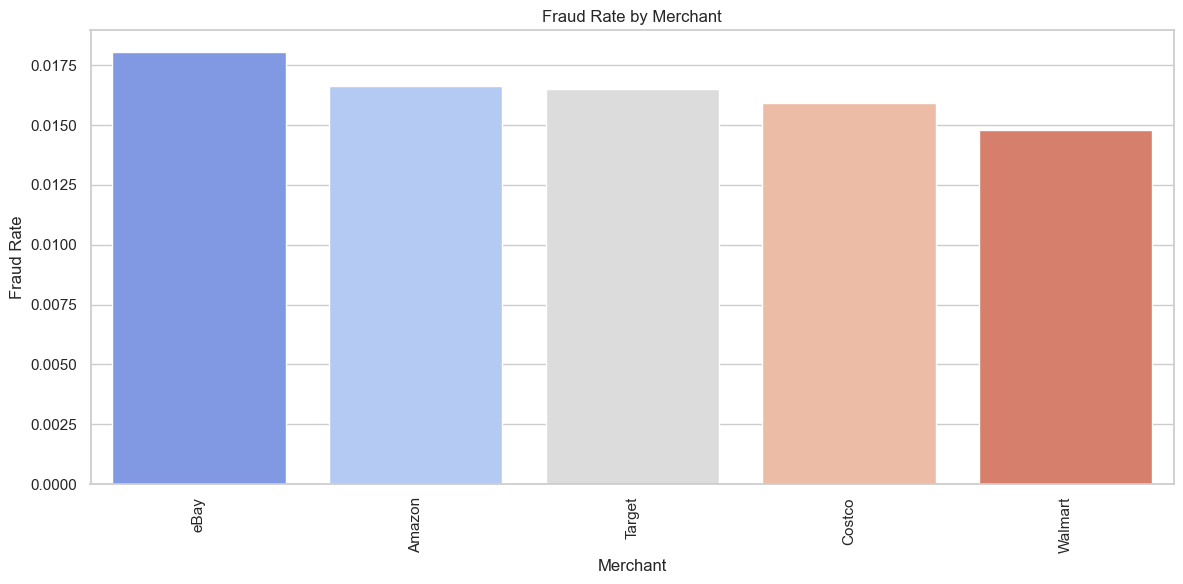

In [37]:
#Fraud Rate by Merchant

agg_df = df.groupby('Merchant').agg(
    F.avg('Class').alias('Fraud_Rate'),
    F.count('*').alias('Total_Transactions')
).orderBy('Fraud_Rate', ascending=False)
agg_pd = agg_df.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=agg_pd, x='Merchant', y='Fraud_Rate', palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Fraud Rate by Merchant')
plt.ylabel('Fraud Rate')
plt.xlabel('Merchant')
plt.tight_layout()
plt.show()

In [38]:
# Fraud Rate By Hour

hourly_df = df.groupby('Hour').agg(
    F.avg('Class').alias('Fraud_Rate'), F.count('*').alias('Transactions'))

hourly_pd = hourly_df.toPandas().sort_values('Hour')

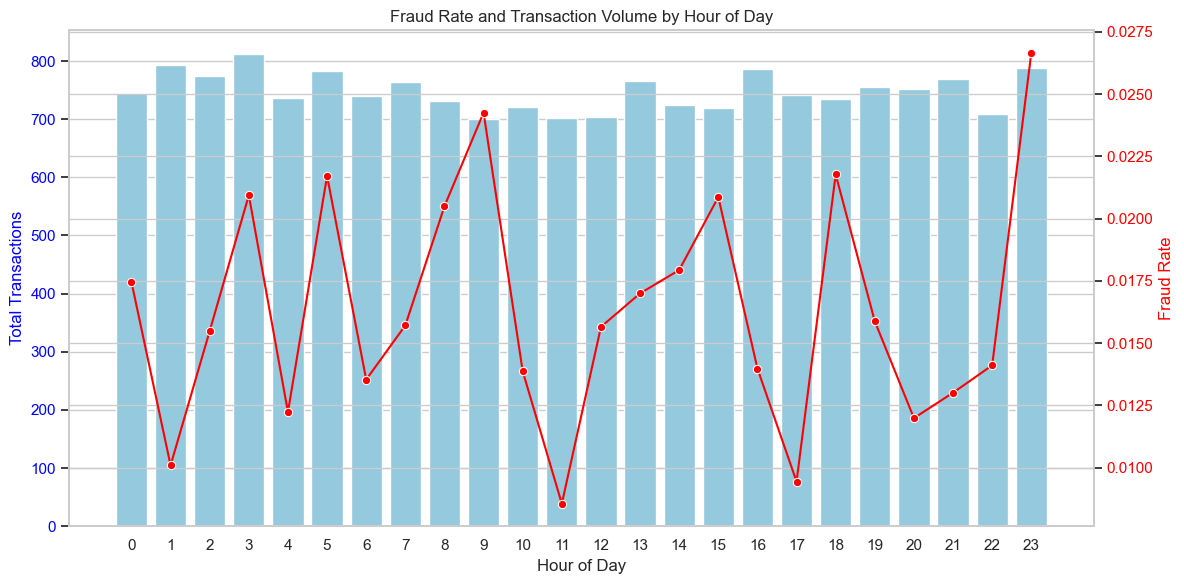

In [39]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x='Hour', y='Transactions', data=hourly_pd, color='skyblue', ax=ax1)
ax1.set_ylabel('Total Transactions', color='blue')
ax1.set_xlabel('Hour of Day')
ax1.tick_params(axis='y', labelcolor='blue')

ax2= ax1.twinx()
sns.lineplot(x='Hour', y='Fraud_Rate', data=hourly_pd, color='red',marker='o',ax=ax2)
ax2.set_ylabel('Fraud Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Fraud Rate and Transaction Volume by Hour of Day')
plt.tight_layout()
plt.show()

In [40]:
# Fraud Ratio per User

user_df = df.groupBy('UserID').agg(
    F.sum('Class').alias('Fraud_Count'), F.count('*').alias('Total_Transaction'),
    (F.sum('Class') / F.count('*')).alias('User_Fraud_Rate')
).orderBy('User_Fraud_Rate', ascending=False)

In [41]:
top_users_pd = user_df.limit(10).toPandas() 

In [42]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col

In [43]:
#Count Frauds by Merchant and TimeOfDay

df.groupBy('Merchant').pivot('TimeOfday').agg(
    F.sum('Class')
).show()

+--------+---------+-------+-------+-----+
|Merchant|Afternoon|Evening|Morning|Night|
+--------+---------+-------+-------+-----+
|  Costco|       12|     10|     16|   20|
| Walmart|       10|      8|     12|   23|
|  Target|       11|     13|     17|   18|
|    eBay|       15|      6|     19|   23|
|  Amazon|       15|      7|     23|   16|
+--------+---------+-------+-------+-----+



In [44]:
# Top Users by Total Spend

df.groupby('UserID').agg(
    F.sum('Amount').alias('Total_Spendings')
).orderBy('Total_Spendings', ascending = False).show(10)

+------+------------------+
|UserID|   Total_Spendings|
+------+------------------+
|  1574|4000.4199999999996|
|  1257|3863.0299999999997|
|  1300|3648.4899999999993|
|  1904|           3642.97|
|  1726|3566.6400000000003|
|  1706|3523.8599999999997|
|  1766|           3511.34|
|  1657|           3476.13|
|  1044|3471.5199999999995|
|  1021|3456.3000000000006|
+------+------------------+
only showing top 10 rows


In [45]:
# Most Common Transaction Amounts

df.groupBy('Amount').count().orderBy('count', ascending=False).show(10)

+------+-----+
|Amount|count|
+------+-----+
| 10.56|    6|
| 27.69|    6|
|   3.4|    6|
|   1.0|    6|
|  7.51|    6|
|  27.9|    6|
|  0.96|    6|
|  9.58|    6|
|  7.55|    6|
|  7.86|    6|
+------+-----+
only showing top 10 rows


In [46]:
#Average transaction amount per merchant

df.groupby('Merchant').agg(
    F.avg('Amount').alias('AvgAmount')
).orderBy('AvgAmount', ascending=False).show(10)

+--------+------------------+
|Merchant|         AvgAmount|
+--------+------------------+
|    eBay|102.62417765042996|
| Walmart|100.57898044692745|
|  Costco|   99.617076119813|
|  Amazon| 98.09351771117166|
|  Target| 97.94831794010658|
+--------+------------------+



In [47]:
# Fraud Distribution by Location

df.groupBy('Location').agg(
    F.avg('Class').alias('Fraud_Rate'),
    F.count('*').alias('Transactions')
).orderBy('Fraud_Rate', ascending=False).show(5)

+--------+--------------------+------------+
|Location|          Fraud_Rate|Transactions|
+--------+--------------------+------------+
|      CA| 0.01690218897201441|        3609|
|      WA|0.016633775021144628|        3547|
|      NY| 0.01632540121748755|        3614|
|      TX|0.016115351993214587|        3537|
|      FL|0.015912208504801097|        3645|
+--------+--------------------+------------+



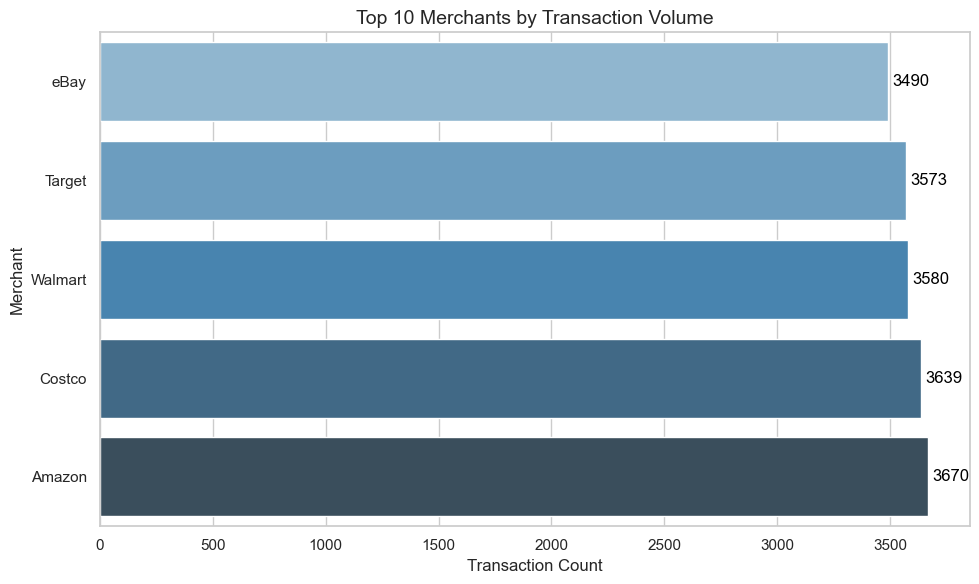

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the data (if not already)
top_merchant = df.groupby('Merchant').count().orderBy('count', ascending=False).limit(10).toPandas()
top_merchant = top_merchant.sort_values('count', ascending=True)  # For horizontal bar chart

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(data=top_merchant, y='Merchant', x='count', palette='Blues_d')

# Add count labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', label_type='edge', padding=3, color='black')

# Titles and labels
plt.title('Top 10 Merchants by Transaction Volume', fontsize=14)
plt.xlabel('Transaction Count')
plt.ylabel('Merchant')
plt.tight_layout()
plt.show()


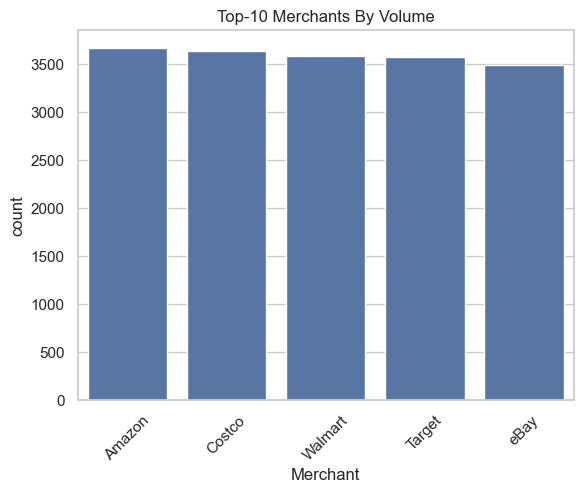

In [49]:
# Top Merchant By Transaction Volume

top_merchant = df.groupby('Merchant').count().orderBy('count',ascending=False).limit(10).toPandas()
sns.barplot(data=top_merchant, x='Merchant', y='count')
plt.xticks(rotation=45)
plt.title('Top-10 Merchants By Volume')
plt.show()

# Model Building

In [50]:
ind = StringIndexer(inputCol='Location', outputCol='Location_Indexed')
df = ind.fit(df).transform(df)

In [51]:
df.limit(5).toPandas()

,UserID,TransactionID,Amount,Time,Location,Merchant,Class,features_unscaled,features_scaled,Hour,TimeOfDay,TransactionFrequency,AvgTransactionAmount,MerchantIndex,MerchantVec,TimeOfDayIndex,TimesOfDayIndex,TimeOfDayVec,Location_Indexed
0,1431,2049,78.43,55330,NY,Target,0,"[78.43, 55330.0]","[-0.2139193209955855, 0.48934342634698946]",15,Afternoon,13,78.450769,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,2.0,"(0.0, 0.0, 1.0)",1.0
1,1519,2050,8.53,32991,FL,Target,0,"[8.53, 32991.0]","[-0.9152809570139177, -0.3981191513256183]",9,Morning,10,87.303000,3.0,"(0.0, 0.0, 0.0, 1.0)",1.0,1.0,"(0.0, 1.0, 0.0)",0.0
2,1789,2051,61.30,15003,FL,Amazon,0,"[61.3, 15003.0]","[-0.3857980738567305, -1.1127293329440824]",4,Night,21,79.989048,0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,0.0,"(1.0, 0.0, 0.0)",0.0
3,1323,2052,66.30,47496,WA,Target,0,"[66.3, 47496.0]","[-0.3356291442416853, 0.17812171393877024]",13,Afternoon,19,79.764211,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,2.0,"(0.0, 0.0, 1.0)",3.0
4,1801,2053,18.13,14743,CA,eBay,0,"[18.13, 14743.0]","[-0.8189566121530308, -1.1230583660339646]",4,Night,20,97.655500,4.0,"(0.0, 0.0, 0.0, 0.0)",0.0,0.0,"(1.0, 0.0, 0.0)",2.0


In [52]:
df = df.drop('TransactionID','UserID','Location','Merchant')

In [53]:
df = df.drop('features_scaled','features_unscaled','TimeOfDay','TimeOfDayIndex')

In [54]:
df.limit(5).toPandas()

,Amount,Time,Class,Hour,TransactionFrequency,AvgTransactionAmount,MerchantIndex,MerchantVec,TimesOfDayIndex,TimeOfDayVec,Location_Indexed
0,78.43,55330,0,15,13,78.450769,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,"(0.0, 0.0, 1.0)",1.0
1,8.53,32991,0,9,10,87.303000,3.0,"(0.0, 0.0, 0.0, 1.0)",1.0,"(0.0, 1.0, 0.0)",0.0
2,61.30,15003,0,4,21,79.989048,0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0
3,66.30,47496,0,13,19,79.764211,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,"(0.0, 0.0, 1.0)",3.0
4,18.13,14743,0,4,20,97.655500,4.0,"(0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",2.0


In [56]:
#Assemble features
from pyspark.ml.feature import VectorAssembler, ChiSqSelector

feature_cols = ["Amount", "Time", "Hour", "TransactionFrequency",
    "AvgTransactionAmount", "MerchantIndex", "TimesOfDayIndex",
    "TimesOfDayIndex", "Location_Indexed"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_assembled = assembler.transform(df)

In [57]:
df_assembled.limit(5).toPandas()

,Amount,Time,Class,Hour,TransactionFrequency,AvgTransactionAmount,MerchantIndex,MerchantVec,TimesOfDayIndex,TimeOfDayVec,Location_Indexed,features
0,78.43,55330,0,15,13,78.450769,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,"(0.0, 0.0, 1.0)",1.0,"[78.43, 55330.0, 15.0, 13.0, 78.45076923076923..."
1,8.53,32991,0,9,10,87.303000,3.0,"(0.0, 0.0, 0.0, 1.0)",1.0,"(0.0, 1.0, 0.0)",0.0,"[8.53, 32991.0, 9.0, 10.0, 87.303, 3.0, 1.0, 1..."
2,61.30,15003,0,4,21,79.989048,0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"[61.3, 15003.0, 4.0, 21.0, 79.98904761904761, ..."
3,66.30,47496,0,13,19,79.764211,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,"(0.0, 0.0, 1.0)",3.0,"[66.3, 47496.0, 13.0, 19.0, 79.7642105263158, ..."
4,18.13,14743,0,4,20,97.655500,4.0,"(0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",2.0,"[18.13, 14743.0, 4.0, 20.0, 97.65549999999999,..."


In [62]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
rf = RandomForestClassifier(featuresCol='features',labelCol='Class', numTrees=10)
pipeline = Pipeline(stages = [assembler, rf])
model = pipeline.fit(df)

In [63]:
rf_model = model.stages[-1]
importances = rf_model.featureImportances

In [64]:
for feature, importance in zip(feature_cols, importances):
    print(f'{feature}:{importance:.4f}')

Amount:0.4378
Time:0.0360
Hour:0.1224
TransactionFrequency:0.1127
AvgTransactionAmount:0.1090
MerchantIndex:0.1144
TimesOfDayIndex:0.0238
TimesOfDayIndex:0.0076
Location_Indexed:0.0364


In [65]:
for feature, importance in zip(feature_cols, importances):
    print(f'{feature}')

Amount
Time
Hour
TransactionFrequency
AvgTransactionAmount
MerchantIndex
TimesOfDayIndex
TimesOfDayIndex
Location_Indexed


In [69]:
top_features = ['Amount','Time','Hour','TransactionFrequency','AvgTransactionAmount','MerchantIndex','Location_Indexed']
assembler = VectorAssembler(inputCols=top_features, outputCol='features_top')
df= assembler.transform(df)

In [70]:
df.limit(5).toPandas()

,Amount,Time,Class,Hour,TransactionFrequency,AvgTransactionAmount,MerchantIndex,MerchantVec,TimesOfDayIndex,TimeOfDayVec,Location_Indexed,features_top
0,78.43,55330,0,15,13,78.450769,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,"(0.0, 0.0, 1.0)",1.0,"[78.43, 55330.0, 15.0, 13.0, 78.45076923076923..."
1,8.53,32991,0,9,10,87.303000,3.0,"(0.0, 0.0, 0.0, 1.0)",1.0,"(0.0, 1.0, 0.0)",0.0,"[8.53, 32991.0, 9.0, 10.0, 87.303, 3.0, 0.0]"
2,61.30,15003,0,4,21,79.989048,0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"[61.3, 15003.0, 4.0, 21.0, 79.98904761904761, ..."
3,66.30,47496,0,13,19,79.764211,3.0,"(0.0, 0.0, 0.0, 1.0)",2.0,"(0.0, 0.0, 1.0)",3.0,"[66.3, 47496.0, 13.0, 19.0, 79.7642105263158, ..."
4,18.13,14743,0,4,20,97.655500,4.0,"(0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",2.0,"[18.13, 14743.0, 4.0, 20.0, 97.65549999999999,..."


In [72]:
# Scale the features
scaler = StandardScaler(inputCol="features_top", outputCol="features", withStd=True, withMean=True)
df_scaled = scaler.fit(df).transform(df)

In [75]:
fraud = df_scaled.filter("Class == 1")
non_fraud = df_scaled.filter("Class == 0")

In [84]:
fraud_train, fraud_test = fraud.randomSplit([0.8, 0.2], seed=42)
nonfraud_train, nonfraud_test = non_fraud.randomSplit([0.8, 0.2], seed=42)

train_df = fraud_train.union(nonfraud_train)
test_df = fraud_test.union(nonfraud_test)

In [85]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="Class", maxIter=100)
gbt_model = gbt.fit(train_df)

gbt_preds = gbt_model.transform(test_df)

25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1010.1 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1010.5 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1012.3 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
25/07/05 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1017.4 KiB
25/07/05 12:33:51 WAR

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction")
print("GBT AUC:", evaluator.evaluate(gbt_preds))

In [94]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
ac = MulticlassClassificationEvaluator(labelCol='Class',
                                             predictionCol='prediction', metricName='accuracy')
f1 = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction',
                                       metricName='f1')
pr = MulticlassClassificationEvaluator(labelCol='prediction', predictionCol='prediction',
                                       metricName='weightedPrecision')
rc = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='weightedRecall')

rocauc= BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [95]:
accuracy = ac.evaluate(gbt_preds)
f1 = ac.evaluate(gbt_preds)
precision = pr.evaluate(gbt_preds)
recall = rc.evaluate(gbt_preds)
roc_auc = evaluator.evaluate(gbt_preds)

25/07/05 12:41:40 WARN DAGScheduler: Broadcasting large task binary with size 1032.9 KiB
25/07/05 12:41:40 WARN DAGScheduler: Broadcasting large task binary with size 1032.9 KiB
25/07/05 12:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1043.2 KiB
25/07/05 12:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1032.9 KiB
25/07/05 12:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB


In [96]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9870
F1 Score: 0.9870
Precision: 1.0000
Recall: 0.9870
ROC-AUC: 0.5713
